In [18]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from matplotlib import pyplot as plot
import numpy as np
import matplotlib.pyplot as plt

In [19]:
class State:
    def __init__(self, x, y):
        self.x = x
        self.y = y

up = lambda state: State(state.x, state.y-1)
down = lambda state: State(state.x, state.y+1)
left = lambda state: State(state.x - 1, state.y)
right = lambda state: State(state.x + 1, state.y)
action_space_size = 4
state_space_size = 63
action_space = [up, down, left, right]

def get_sample():
    random_pos = np.random.randint(0,4)
    return action_space[random_pos], random_pos

def get_num_state(state):
    return state.y*9 + state.x

def reset():
    initial_state = State(1,1)
    return initial_state,get_num_state(initial_state)

def is_goal_state(state):
    return state.x == 7 and state.y == 4

def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 126
    return -1

def move(state, action):
    wind_val = {3:0.1, 4:0.2, 5:0.15}
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward = get_reward(new_state)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

#reward treshold is the value we defined as the reward the agent should reach in order to tell it learned to reach the goal in an optimum way
reward_treshold = 115

def rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
    # This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learns to maximize the reward.
    rewards_avg = []
    q_table_avg = []
    num_times_goal_reached_avg = []
    for it in range(100):
        #print('average ', it)
        rewards_all_episodes=[]
        q_table_all_episodes = []
        num_times_goal_reached = 0
       # num_episodes_reward_treshold_avg = -1
        # exporation-exploitation trade-off params
        exploration_rate = 1

        # init q table in zeros
        q_table = np.zeros((state_space_size, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            state, num_state = reset()
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.random()
                if exploration_rate_threshold <= exploration_rate:
                    action, pos_action = get_sample()
                else:
                    q_row = q_table[num_state]
                    pos_action = np.where(q_row == max(q_row))[0][0]
                    action = action_space[pos_action]
                # Take action
                new_state, reward, done = move(state, action)
                if new_state == None:
                    num_new_state = get_num_state(state)
                else:
                    num_new_state = get_num_state(new_state)
                # Update Q-table for Q(s,a)
                max_value = max(q_table[num_new_state])
                future_q=learning_rate*(reward + discount_rate*max_value)
                q_table[num_state, pos_action] = (1-learning_rate)*q_table[num_state,pos_action] + future_q

                # transition next state
                state = new_state
                num_state = num_new_state
                rewards_current_episode += reward
                        
                if done == True: 
                    break

            # Exploration rate decay
            exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
            
            if state!=None and is_goal_state(state):
                num_times_goal_reached += 1
                
            rewards_all_episodes.append(rewards_current_episode)
            q_table_all_episodes.append(q_table)
            
        num_times_goal_reached_avg.append(num_times_goal_reached)        
        rewards_avg.append(rewards_all_episodes)
        q_table_avg.append(q_table_all_episodes)
    return rewards_avg, q_table, num_times_goal_reached_avg
        
def plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath):
    x = [i for i in range(0,num_episodes)]
    y = np.mean(rewards_avg, axis=0)
    plot.xlabel('Episodes')
    plot.ylabel('Reward')
    plot.plot(x, y,'o')
    plot.title("Episodes_vs_Rewards")
    plt.savefig(filepath)
    plt.show()
    
def get_state_actions(q_table):
    q_table_best_actions =[]
    for i in range(q_table.shape[0]):
        max_pos = np.argmax(q_table[i])
        q_table_best_actions.append(max_pos)
    return q_table_best_actions
    
def plot_optimal_policy(q_table, filepath):
    w = 0.3
    i,j=0,0
    best_actions_matrix = np.array(get_state_actions(q_table)).reshape(7,9)
    arrow_dict = {0:lambda i,j:plt.arrow(x=i, y=j-0.25, dx=0, dy=w, width=.05)  ,1:lambda i,j:plt.arrow(x=i, y=j+0.25, dx=0, dy=-w, width=.05),2:lambda i,j:plt.arrow(x=i+0.2, y=j, dx=-w, dy=0, width=.05),3:lambda i,j:plt.arrow(x=i-0.2, y=j, dx=w, dy=0, width=.05)}
    arrow_matrix=np.transpose(np.array(best_actions_matrix).reshape(7,9))
    for j in range(len(arrow_matrix)):
        for i in range(len(arrow_matrix[j])):
            arrow_dict[best_actions_matrix[i,j]](j+0.5,(6-i)+0.5)
    start = [1,1]
    goal = [7,4]
    plt.scatter(start[0]+0.5,6-start[1]+0.5, color="green", linewidths=20)
    plt.scatter(goal[0]+0.5,6-goal[1]+0.5, color = "blue",linewidths=20)
    plt.xticks(np.arange(9,-1, -1))
    plt.yticks(np.arange(7,-1, -1),labels= ["0","1","2","3","4","5","6","7"])
    plt.grid()
    plt.title("Optimal_Policy_Actions")
    # display plot 
    plt.savefig(filepath)
    plt.show()

def get_max_reward_avg_episode(rewards_avg):
    max_rew_avg = []
    for rew in rewards_avg:
        max_rew_pos = np.argmax(np.array(rew))
        max_rew_avg.append(max_rew_pos)
    return np.mean(max_rew_avg)
    
def save_rewards(filename, rewards_avg):
    np.save(filename,rewards_avg)
    
def load_rewards(filename):
    rewards_avg =np.load(filename)
    return rewards_avg

#### Version 1
    learning_rate = 0.2
    discount_rate = 0.95
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005

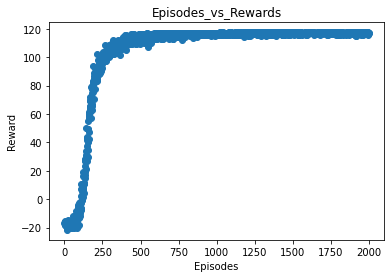

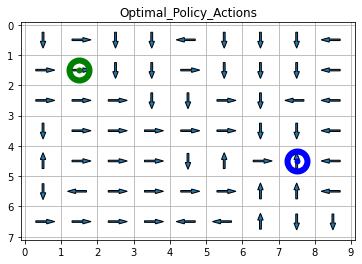

Average number of times goal was reached:  1826.3  representing 91.315 %
Average episode number in which the agent was able to learn:  159.24


In [20]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v1.jpg"
filepath_optimal_policy = "optimal_policies/v1.jpg"
filepath_rewards = "rewards/rewards_v1.npy"

rewards_avg, q_table, num_times_goal_reached= rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 2
    learning_rate = 0.1
    discount_rate = 0.93
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005

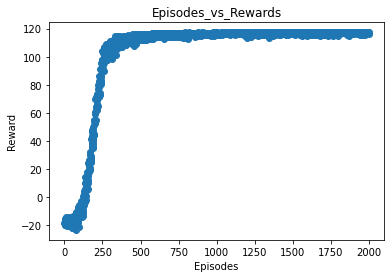

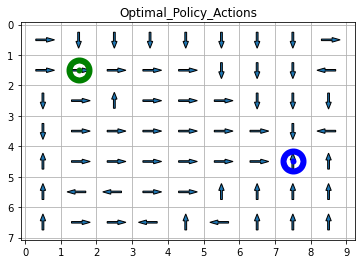

Average number of times goal was reached:  1803.4  representing 90.17 %
Average episode number in which the agent was able to learn:  186.02


In [21]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.1
discount_rate = 0.93
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v2.jpg"
filepath_optimal_policy = "optimal_policies/v2.jpg"
filepath_rewards = "rewards/rewards_v2.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 3
    learning_rate = 0.01
    discount_rate = 0.80
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005

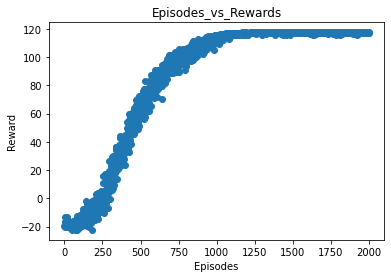

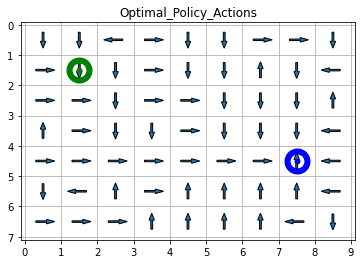

Average number of times goal was reached:  1587.08  representing 79.35399999999998 %
Average episode number in which the agent was able to learn:  356.89


In [22]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.01
discount_rate = 0.80
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v3.jpg"
filepath_optimal_policy = "optimal_policies/v3.jpg"
filepath_rewards = "rewards/rewards_v3.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 4
    learning_rate = 0.3
    discount_rate = 0.98
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005

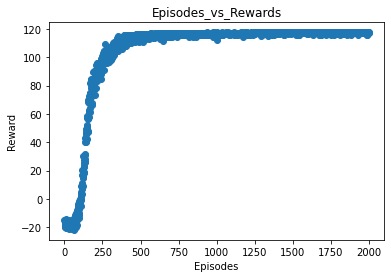

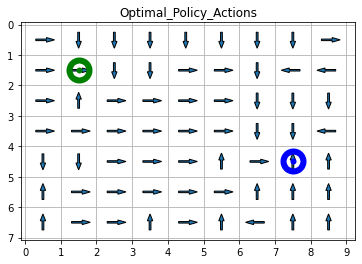

Average number of times goal was reached:  1834.8  representing 91.74 %
Average episode number in which the agent was able to learn:  155.98


In [23]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.3
discount_rate = 0.98
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v4.jpg"
filepath_optimal_policy = "optimal_policies/v4.jpg"
filepath_rewards = "rewards/rewards_v4.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 5
    learning_rate = 0.5
    discount_rate = 0.98
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005

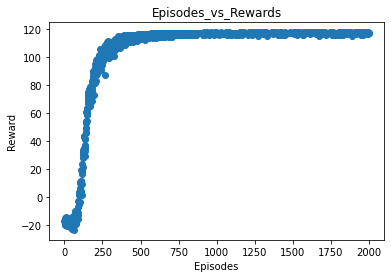

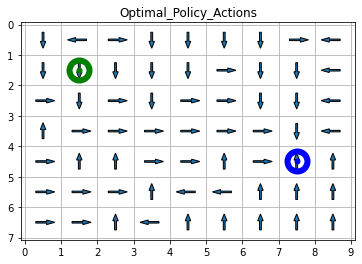

Average number of times goal was reached:  1844.48  representing 92.224 %
Average episode number in which the agent was able to learn:  148.17


In [24]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.5
discount_rate = 0.98
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v5.jpg"
filepath_optimal_policy = "optimal_policies/v5.jpg"
filepath_rewards = "rewards/rewards_v5.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))